In [32]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# File paths
finetuned_eval = '/Users/ryanarman/code/lab/arxiv_abstract/data/fine_tuned_eval_qwen3_4b_test.jsonl'
original_eval = '/Users/ryanarman/code/lab/arxiv_abstract/data/original_eval_qwen3_4b_test.jsonl'
base_eval = '/Users/ryanarman/code/lab/arxiv_abstract/data/baseline_eval_qwen3_4b_test.jsonl'

def parse_scores(explanation):
    """
    Parse scores from explanation text, handling different formats:
    - "Faithfulness (78/100):"
    - "Faithfulness: 78/100"
    - "Faithfulness (78):"
    - "Faithfulness (0-100): 92"
    - "Faithfulness (accuracy to the paper): 95/100"
    - "Overall (82/100):"
    """
    scores = {}
    
    if not explanation or not isinstance(explanation, str):
        return scores
    
    # Dimensions to extract
    dimensions = ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence', 'Overall']
    
    for dim in dimensions:
        # Try different patterns - order matters (more specific first)
        patterns = [
            # Formats with "score:" keyword
            rf'{dim}\s+score:\s*(\d+)/100',               # "Faithfulness score: 5/100"
            rf'{dim}\s+score:\s*(\d+)',                   # "Faithfulness score: 5"
            
            # Standard formats with parentheses and /100
            rf'{dim}\s*\((\d+)/100\)',                    # "Faithfulness (78/100):"
            rf'{dim}\s*\([^)]*\):\s*(\d+)/100',           # "Faithfulness (accuracy to the paper): 95/100"
            rf'{dim}\s*\([^)]*\):\s*(\d+)',               # "Faithfulness (0-100): 92"
            rf'{dim}\s*\((\d+)\)',                        # "Faithfulness (78):"
            
            # Formats with colon
            rf'{dim}:\s*(\d+)/100',                       # "Faithfulness: 78/100"
            rf'{dim}:\s*(\d+)',                           # "Faithfulness: 78"
            
            # Formats with space
            rf'{dim}\s+(\d+)/100',                        # "Faithfulness 78/100"
            rf'{dim}\s+(\d+)',                            # "Faithfulness 78"
            
            # Formats with dash
            rf'{dim}\s*[–-]\s*(\d+)/100',                 # "Faithfulness - 78/100"
            rf'{dim}\s*[–-]\s*(\d+)',                     # "Faithfulness - 78"
            
            # Look for score on next line after dimension header
            rf'{dim}\s*\([^)]*\):\s*\n\s*(\d+)/100',      # "Faithfulness (...):\n78/100"
            rf'{dim}\s*\([^)]*\):\s*\n\s*(\d+)',          # "Faithfulness (...):\n78"
        ]
        
        for pattern in patterns:
            match = re.search(pattern, explanation, re.IGNORECASE | re.MULTILINE)
            if match:
                try:
                    score = int(match.group(1))
                    # Validate score is in reasonable range
                    if 0 <= score <= 100:
                        scores[dim] = score
                        break
                except (ValueError, IndexError):
                    continue
    
    return scores

def load_eval_results(filepath):
    """Load evaluation results from JSONL file"""
    results = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                data = json.loads(line)
                scores = parse_scores(data.get('explanation', ''))
                results.append({
                    'index': data.get('index', len(results)),
                    'judgment': data.get('judgment', ''),
                    'scores': scores,
                    'explanation': data.get('explanation', '')
                })
    return results

# Load all results
print("Loading evaluation results...")
finetuned_results = load_eval_results(finetuned_eval)
original_results = load_eval_results(original_eval)
base_results = load_eval_results(base_eval)

print(f"Loaded {len(finetuned_results)} fine-tuned results")
print(f"Loaded {len(original_results)} original results")
print(f"Loaded {len(base_results)} baseline results")

# Create comparison DataFrame
def create_comparison_df(results_list, names):
    """Create a comparison DataFrame from multiple result sets"""
    all_data = []
    dimensions = ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence', 'Overall']
    
    for idx in range(len(results_list[0])):
        row = {'index': idx}
        for i, (results, name) in enumerate(zip(results_list, names)):
            if idx < len(results):
                result = results[idx]
                row[f'{name}_judgment'] = result['judgment']
                for dim in dimensions:
                    score = result['scores'].get(dim, np.nan)
                    row[f'{name}_{dim}'] = score
        all_data.append(row)
    
    return pd.DataFrame(all_data)

# Create comparison DataFrame
comparison_df = create_comparison_df(
    [finetuned_results, original_results, base_results],
    ['finetuned', 'original', 'base']
)

print("\nComparison DataFrame created!")
print(f"Shape: {comparison_df.shape}")
print("\nFirst few rows:")
print(comparison_df.head())


Loading evaluation results...
Loaded 1000 fine-tuned results
Loaded 1000 original results
Loaded 1000 baseline results

Comparison DataFrame created!
Shape: (1000, 22)

First few rows:
   index finetuned_judgment  finetuned_Faithfulness  finetuned_Coverage  \
0      0                Yes                    78.0                85.0   
1      1                Yes                    85.0                70.0   
2      2                Yes                    85.0                80.0   
3      3                 No                    28.0                32.0   
4      4                 No                    25.0                25.0   

   finetuned_Clarity  finetuned_Conciseness  finetuned_Coherence  \
0               72.0                   90.0                 85.0   
1               85.0                   92.0                 85.0   
2               80.0                   92.0                 85.0   
3               68.0                   90.0                 75.0   
4               35.0    

In [33]:
# Debug: Find entries with missing scores
def find_missing_scores(results_list, names):
    """Find entries where scores are missing"""
    dimensions = ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence', 'Overall']
    
    for results, name in zip(results_list, names):
        missing_count = 0
        missing_examples = []
        
        for idx, result in enumerate(results):
            scores = result['scores']
            missing_dims = [dim for dim in dimensions if dim not in scores]
            
            if missing_dims:
                missing_count += 1
                if len(missing_examples) < 5:  # Show first 5 examples
                    missing_examples.append({
                        'index': result['index'],
                        'missing_dims': missing_dims,
                        'explanation_preview': result['explanation'][:200] if result['explanation'] else 'No explanation',
                        'judgment': result['judgment']
                    })
        
        print(f"\n{name.upper()} - Missing scores in {missing_count}/{len(results)} entries")
        if missing_examples:
            print("\nSample entries with missing scores:")
            for ex in missing_examples:
                print(f"  Index {ex['index']}: Missing {ex['missing_dims']}")
                print(f"    Judgment: {ex['judgment']}")
                print(f"    Explanation preview: {ex['explanation_preview']}...")
                print()

find_missing_scores([finetuned_results, original_results, base_results], 
                    ['finetuned', 'original', 'base'])



FINETUNED - Missing scores in 63/1000 entries

Sample entries with missing scores:
  Index 10: Missing ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence', 'Overall']
    Judgment: No
    Explanation preview: Faithfulness (Score: 25/100)
- The summary contains multiple inaccuracies and hallucinations. It claims the work shows “greater cooperative effects than ref. @xcite,” while the paper reports modest co...

  Index 17: Missing ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence', 'Overall']
    Judgment: No
    Explanation preview: Faithfulness (score: 5/100):
- The response contains multiple hallucinations and incorrect claims not supported by the paper. It talks about “intramolecular yields,” “dissipative electron correlation ...

  Index 33: Missing ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence', 'Overall']
    Judgment: No
    Explanation preview: Faithfulness (Score: 35/100)
- The summary contains multiple unsupported and incorr

In [34]:
comparison_df.columns

Index(['index', 'finetuned_judgment', 'finetuned_Faithfulness',
       'finetuned_Coverage', 'finetuned_Clarity', 'finetuned_Conciseness',
       'finetuned_Coherence', 'finetuned_Overall', 'original_judgment',
       'original_Faithfulness', 'original_Coverage', 'original_Clarity',
       'original_Conciseness', 'original_Coherence', 'original_Overall',
       'base_judgment', 'base_Faithfulness', 'base_Coverage', 'base_Clarity',
       'base_Conciseness', 'base_Coherence', 'base_Overall'],
      dtype='object')

In [35]:
comparison_df[['original_judgment', 'base_judgment', 'finetuned_judgment']].head(10)

,original_judgment,base_judgment,finetuned_judgment
0,Yes,Yes,Yes
1,Yes,Yes,Yes
2,No,Yes,Yes
3,Yes,Yes,No
4,Yes,No,No
5,Yes,Yes,No
6,Yes,No,No
7,No,No,Yes
8,Yes,No,No
9,No,Yes,No


In [36]:
comparison_df[['original_Overall', 'base_Overall', 'finetuned_Overall']].head(10)

,original_Overall,base_Overall,finetuned_Overall
0,91.0,94.0,82.0
1,88.0,88.0,79.0
2,62.0,92.0,84.0
3,87.0,90.0,50.0
4,88.0,72.0,33.0
5,85.0,88.0,10.0
6,88.0,68.0,36.0
7,70.0,77.0,84.0
8,91.0,78.0,11.0
9,65.0,88.0,42.0


# Yes/No judgment comparison

In [37]:
dimensions = ['Faithfulness', 'Coverage', 'Clarity', 'Conciseness', 'Coherence', 'Overall']
models = ['finetuned', 'original', 'base']

In [38]:

print("Judgment (Yes/No) Comparison:")
print("=" * 80)

judgment_counts = {}
for model in models:
    col = f'{model}_judgment'
    if col in comparison_df.columns:
        counts = comparison_df[col].value_counts()
        judgment_counts[model] = counts
        print(f"\n{model.upper()}:")
        print(counts)
        if len(counts) > 0:
            yes_pct = (counts.get('Yes', 0) / len(comparison_df[col].dropna()) * 100) if len(comparison_df[col].dropna()) > 0 else 0
            print(f"  Yes: {yes_pct:.1f}%")

# Create judgment comparison DataFrame
judgment_df = pd.DataFrame(judgment_counts).fillna(0)
print("\n\nJudgment Counts Table:")
print(judgment_df)


Judgment (Yes/No) Comparison:

FINETUNED:
finetuned_judgment
No     930
Yes     70
Name: count, dtype: int64
  Yes: 7.0%

ORIGINAL:
original_judgment
Yes    748
No     252
Name: count, dtype: int64
  Yes: 74.8%

BASE:
base_judgment
No     503
Yes    497
Name: count, dtype: int64
  Yes: 49.7%


Judgment Counts Table:
     finetuned  original  base
No         930       252   503
Yes         70       748   497


# Calculate summary statistics

In [39]:
summary_stats = []
for dim in dimensions:
    for model in models:
        col = f'{model}_{dim}'
        if col in comparison_df.columns:
            scores = comparison_df[col].dropna()
            if len(scores) > 0:
                summary_stats.append({
                    'Dimension': dim,
                    'Model': model,
                    'Mean': scores.mean(),
                    'Std': scores.std(),
                    'Min': scores.min(),
                    'Max': scores.max(),
                    'Median': scores.median(),
                    'Count': len(scores)
                })

summary_df = pd.DataFrame(summary_stats)
print("Summary Statistics by Dimension and Model:")
print("=" * 80)
print(summary_df.to_string(index=False))

# Pivot for easier comparison
pivot_mean = summary_df.pivot(index='Dimension', columns='Model', values='Mean')
print("\n\nMean Scores Comparison:")
print("=" * 80)
print(pivot_mean.round(2))

# Calculate improvements
print("\n\nFine-tuned vs Baseline Improvements:")
print("=" * 80)
improvements = []
for dim in dimensions:
    base_col = f'base_{dim}'
    finetuned_col = f'finetuned_{dim}'
    if base_col in comparison_df.columns and finetuned_col in comparison_df.columns:
        base_mean = comparison_df[base_col].mean()
        finetuned_mean = comparison_df[finetuned_col].mean()
        improvement = finetuned_mean - base_mean
        improvement_pct = (improvement / base_mean * 100) if base_mean > 0 else 0
        improvements.append({
            'Dimension': dim,
            'Baseline': base_mean,
            'Fine-tuned': finetuned_mean,
            'Improvement': improvement,
            'Improvement %': improvement_pct
        })

improvements_df = pd.DataFrame(improvements)
print(improvements_df.round(2).to_string(index=False))


Summary Statistics by Dimension and Model:
   Dimension     Model      Mean       Std  Min  Max  Median  Count
Faithfulness finetuned 32.035219 25.075651  0.0 98.0    30.0    937
Faithfulness  original 83.231006 14.603179 30.0 98.0    90.0    974
Faithfulness      base 71.597192 19.692961 10.0 97.0    78.0    926
    Coverage finetuned 41.592316 25.143738  0.0 95.0    40.0    937
    Coverage  original 78.204312 10.824696 20.0 95.0    80.0    974
    Coverage      base 89.062635  4.091701 50.0 96.0    90.0    926
     Clarity finetuned 41.330843 26.962926  0.0 92.0    40.0    937
     Clarity  original 84.522587  8.662746 30.0 96.0    88.0    974
     Clarity      base 91.885529  3.639701 60.0 96.0    92.0    926
 Conciseness finetuned 53.138741 33.485166  0.0 98.0    60.0    937
 Conciseness  original 90.952772  9.209106 20.0 98.0    95.0    974
 Conciseness      base 90.063715  2.796763 80.0 96.0    90.0    926
   Coherence finetuned 43.551761 30.096031  0.0 95.0    45.0    937
   Co

# Visualizations


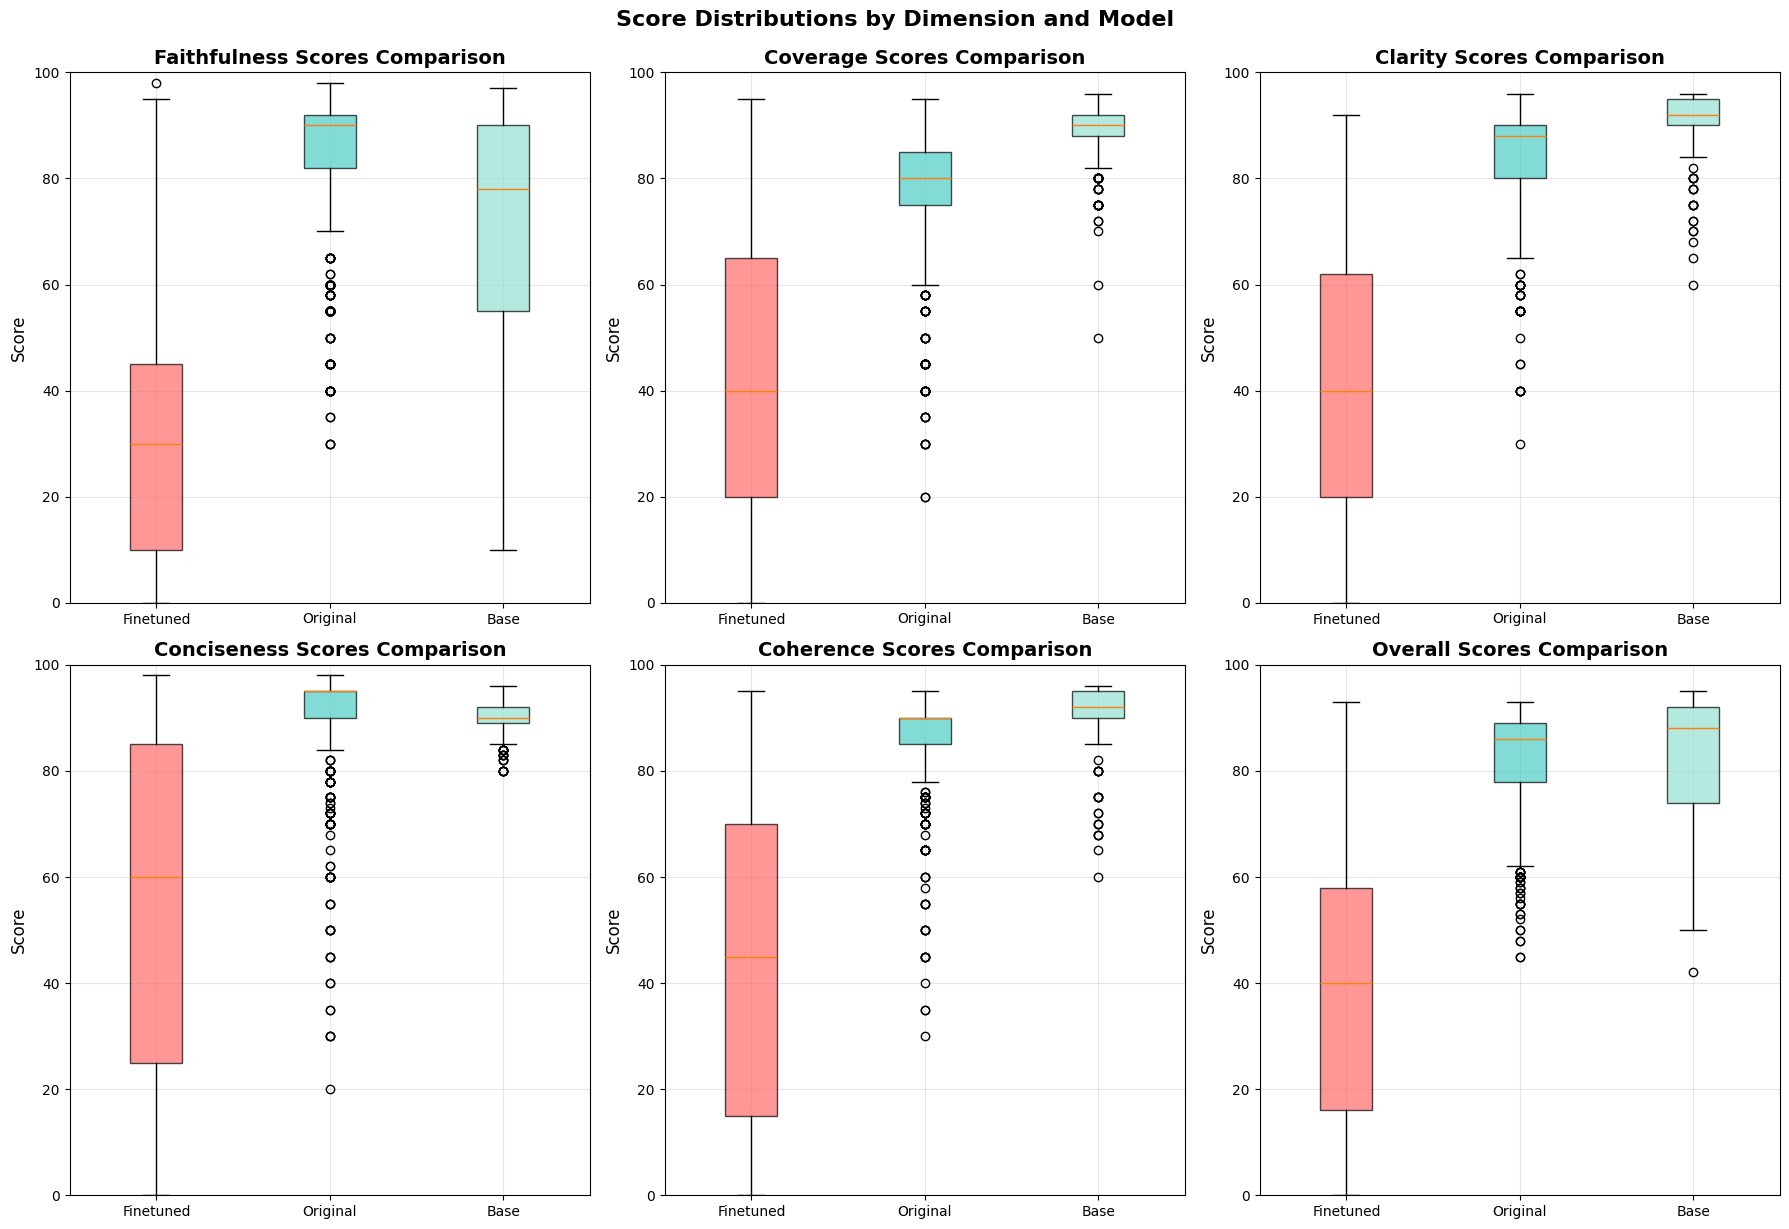

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, dim in enumerate(dimensions):
    ax = axes[idx]
    
    # Prepare data for box plot
    data_to_plot = []
    labels = []
    for model in models:
        col = f'{model}_{dim}'
        if col in comparison_df.columns:
            scores = comparison_df[col].dropna().tolist()
            if scores:
                data_to_plot.append(scores)
                labels.append(model.capitalize())
    
    if data_to_plot:
        bp = ax.boxplot(data_to_plot, tick_labels=labels, patch_artist=True)
        
        # Color the boxes
        colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']
        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_title(f'{dim} Scores Comparison', fontsize=14, fontweight='bold')
        ax.set_ylabel('Score', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 100)

plt.tight_layout()
plt.suptitle('Score Distributions by Dimension and Model', fontsize=16, fontweight='bold', y=1.02)
plt.show()


# Bar plot comparing mean scores


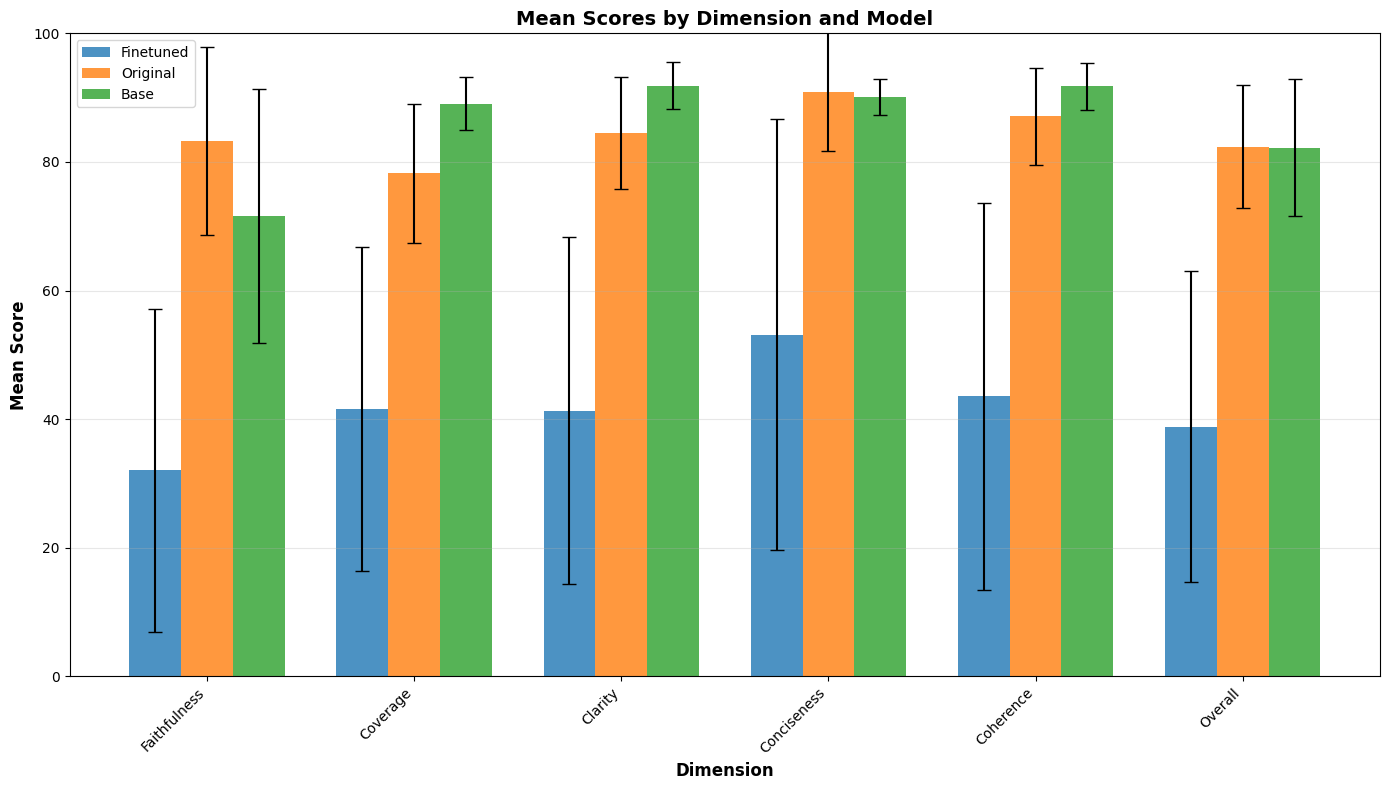

In [41]:
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(dimensions))
width = 0.25

for i, model in enumerate(models):
    means = []
    stds = []
    for dim in dimensions:
        col = f'{model}_{dim}'
        if col in comparison_df.columns:
            scores = comparison_df[col].dropna()
            means.append(scores.mean() if len(scores) > 0 else 0)
            stds.append(scores.std() if len(scores) > 0 else 0)
        else:
            means.append(0)
            stds.append(0)
    
    offset = (i - 1) * width
    ax.bar(x + offset, means, width, label=model.capitalize(), 
           yerr=stds, capsize=5, alpha=0.8)

ax.set_xlabel('Dimension', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Score', fontsize=12, fontweight='bold')
ax.set_title('Mean Scores by Dimension and Model', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(dimensions, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()


# Heatmap of mean scores


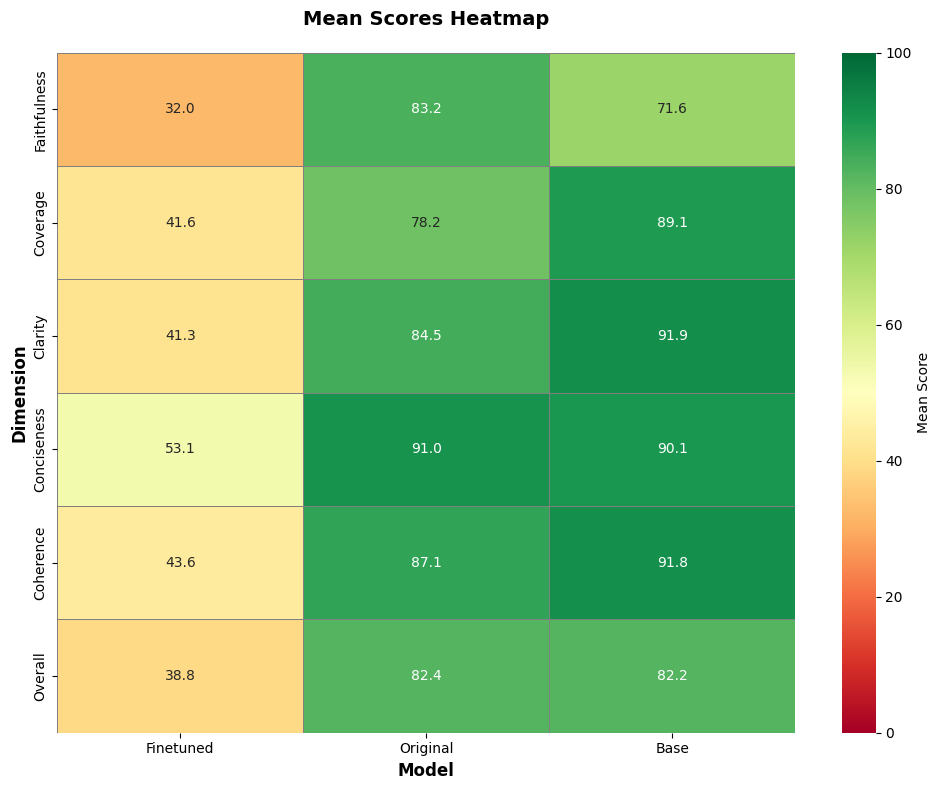

In [42]:
heatmap_data = []
for dim in dimensions:
    row = []
    for model in models:
        col = f'{model}_{dim}'
        if col in comparison_df.columns:
            mean_score = comparison_df[col].mean()
            row.append(mean_score)
        else:
            row.append(np.nan)
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, index=dimensions, columns=[m.capitalize() for m in models])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='RdYlGn', 
            vmin=0, vmax=100, cbar_kws={'label': 'Mean Score'}, 
            linewidths=0.5, linecolor='gray')
plt.title('Mean Scores Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Dimension', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


# Export comparison results to CSV


In [43]:
output_file = '/Users/ryanarman/code/lab/arxiv_abstract/data/evaluation_comparison.csv'
comparison_df.to_csv(output_file, index=False)
print(f"Comparison results exported to: {output_file}")

# Export summary statistics
summary_file = '/Users/ryanarman/code/lab/arxiv_abstract/data/evaluation_summary_stats.csv'
summary_df.to_csv(summary_file, index=False)
print(f"Summary statistics exported to: {summary_file}")

# Export improvements
if len(improvements_df) > 0:
    improvements_file = '/Users/ryanarman/code/lab/arxiv_abstract/data/evaluation_improvements.csv'
    improvements_df.to_csv(improvements_file, index=False)
    print(f"Improvements data exported to: {improvements_file}")

print("\nAll comparison data has been exported!")


Comparison results exported to: /Users/ryanarman/code/lab/arxiv_abstract/data/evaluation_comparison.csv
Summary statistics exported to: /Users/ryanarman/code/lab/arxiv_abstract/data/evaluation_summary_stats.csv
Improvements data exported to: /Users/ryanarman/code/lab/arxiv_abstract/data/evaluation_improvements.csv

All comparison data has been exported!
